In [1]:
#uncomment this if you are not using puffer
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

#my container always require reinstalling these dependencies; uncomment this if you don't need to
!pip install -U spacy
!pip install torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are using ", device)

import numpy as np
import spacy

import random
import math
import time

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

     |████████████████████████████████| 6.1 MB 1.1 MB/s            
     |████████████████████████████████| 42 kB 702 kB/s             
     |████████████████████████████████| 181 kB 12.5 MB/s            
     |████████████████████████████████| 11.3 MB 317 kB/s             
     |████████████████████████████████| 452 kB 11.5 MB/s            
     |████████████████████████████████| 635 kB 12.6 MB/s            
     |████████████████████████████████| 9.9 MB 61 kB/s              
     |████████████████████████████████| 128 kB 9.9 MB/s            
     |████████████████████████████████| 58 kB 2.6 MB/s             
     |████████████████████████████████| 8.0 MB 977 kB/s            
     |████████████████████████████████| 881.9 MB 7.6 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
     |████████████████████████████████| 13.9 MB 10.7 MB/s            
✔ Download and install

# 6 - TorchText + CNN + Attention + Greedy Decoding + BLEU

In this notebook we'll be implementing the [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122) model. 

![](assets/convseq2seq0.png)

## Introduction

This model is drastically different to the previous models used in these tutorials. There are no recurrent components used at all. Instead it makes use of convolutional layers, typically used for image processing. For an introduction to convolutional layers on text for sentiment analysis, look at the classification folder CNN for NLP tutorial. 

In short, a convolutional layer uses *filters*. These filters have a *width* (and also a *height* in images, but usually not text). If a filter has a width of 3, then it can see 3 consecutive tokens. Each convolutional layer has many of these filters (1024 in this tutorial). Each filter will slide across the sequence, from beginning to the end, looking at all 3 consectuive tokens at a time. The idea is that each of these 1024 filters will learn to extract a different feature from the text. The result of this feature extraction will then be used by the model - potentially as input to another convolutional layer. This can then all be used to extract features from the source sentence to translate it into the target language.

**Note: in this notebook we are using CNNs which expect the batch dimension to be first. We tell TorchText to have batches be <code>[batch size, sequence length]</code> by setting <code>batch_first</code> = True** in the <code>collate_fn</code>

This is edited from https://github.com/bentrevett.

## 1. Preprocessing

### Load the dataset

In [2]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'
train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

100%|██████████| 1.21M/1.21M [00:02<00:00, 591kB/s] 
100%|██████████| 46.3k/46.3k [00:00<00:00, 113kB/s] 
100%|██████████| 43.9k/43.9k [00:00<00:00, 108kB/s] 


In [3]:
len(train_iter)

29000

In [4]:
#let's try print one train sample
#a pair of src sentence (de) and target sentence (en)
sample = next(train_iter)
sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.\n',
 'Two young, White males are outside near many bushes.\n')

### Tokenizers

In [5]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [6]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
#example of tokenization of the english part
print("English sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

English sentence:  Two young, White males are outside near many bushes.

Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n']


In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

In [10]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[2208, 11, 4, 0, 4]

In [12]:
len(vocab_transform[TRG_LANGUAGE])

6192

### Batch Iterator

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) #<--------add batch_first
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [14]:
from torchtext.data.functional import to_map_style_dataset

train_iter, valid_iter, test_iter = Multi30k(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

#if we simply use train_iter, once we run it, it cannot be iterate more, so let's convert to map style dataset
train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_fn)

In [15]:
src, _, trg = next(iter(train_loader))
print("src shape: ", src.shape) # (batch_size, seq len)
print("trg shape: ", trg.shape) # (batch_size, seq len)

src shape:  torch.Size([64, 25])
trg shape:  torch.Size([64, 26])


## 2. Building the Model

Next up is building the model. As before, the model is made of an encoder and decoder. The encoder *encodes* the input sentence, in the source language, into a *context vector*. The decoder *decodes* the context vector to produce the output sentence in the target language.

### Encoder

The image below shows the result of an input sentence - *zwei menschen fechten.* - being passed through the encoder.

![](assets/convseq2seq1.png)

First, the token is passed through a *token embedding layer* - which is standard for neural networks in natural language processing. However, as there are no recurrent connections in this model it has no idea about the order of the tokens within a sequence. To rectify this we have a second embedding layer, the *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence - starting with the first token, the `<sos>` (start of sequence) token, in position 0.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence - which we simply call the *embedding vector*. This is followed by a linear layer which transforms the embedding vector into a vector with the required hidden dimension size. 

The next step is to pass this hidden vector into $N$ *convolutional blocks*. This is where the "magic" happens in this model and we will detail the contents of the convolutional blocks shortly. After passing through the convolutional blocks, the vector is then fed through another linear layer to transform it back from the hidden dimension size into the embedding dimension size. This is our *conved* vector - and we have one of these per token in the input sequence. 

Finally, the conved vector is elementwise summed with the embedding vector via a residual connection to get a *combined* vector for each token. Again, there is a combined vector for each token in the input sequence.

### Convolutional Blocks

So, how do these convolutional blocks work? The below image shows 2 convolutional blocks with a single filter (blue) that is sliding across the tokens within the sequence. In the actual implementation we will have 10 convolutional blocks with 1024 filters in each block.

![](assets/convseq2seq2.png)

First, the input sentence is padded. This is because the convolutional layers will reduce the length of the input sentence and we want the length of the sentence coming into the convolutional blocks to equal the length of it coming out of the convolutional blocks. Without padding, the length of the sequence coming out of a convolutional layer will be `filter_size - 1` shorter than the sequence entering the convolutional layer. For example, if we had a filter size of 3, the sequence will be 2 elements shorter. Thus, we pad the sentence with one padding element on each side. We can calculate the amount of padding on each side by simply doing `(filter_size - 1)/2` for odd sized filters - we will not cover even sized filters in this tutorial.

These filters are designed so the output hidden dimension of them is twice the input hidden dimension. In computer vision terminology these hidden dimensions are called *channels* - but we will stick to calling them hidden dimensions. Why do we double the size of the hidden dimension leaving the convolutional filter? This is because we are using a special activation function called *gated linear units* (GLU). GLUs have gating mechanisms (similar to LSTMs and GRUs) contained within the activation function and actually half the size of the hidden dimension - whereas usually activation functions keep the hidden dimensions the same size.

After passing through the GLU activation the hidden dimension size for each token is the same as it was when it entered the convolutional blocks. It is now elementwise summed with its own vector before it was passed through the convolutional layer. 

This concludes a single convolutional block. Subsequent blocks take the output of the previous block and perform the same steps. Each block has their own parameters, they are not shared between blocks. The output of the last block goes back to the main encoder - where it is fed through a linear layer to get the conved output and then elementwise summed with the embedding of the token to get the combined output.

### Encoder Implementation

To keep the implementation simple, we only allow for odd sized kernels. This allows padding to be added equally to both sides of the source sequence.

The `scale` variable is used at the residual connection by the authors to "ensure that the variance throughout the network does not change dramatically". The performance of the model seems to vary wildly using different seeds if this is not used.

The positional embedding is initialized to have a "vocabulary" of 100. This means it can handle sequences up to 100 elements long, indexed from 0 to 99. This can be increased if used on a dataset with longer sequences.

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, 
                 kernel_size, dropout, device, max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))
            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

### Decoder

The decoder takes in the actual target sentence and tries to predict it. This model differs from the recurrent neural network models previously detailed in these tutorials as it predicts all tokens within the target sentence in parallel. There is no sequential processing, i.e. no decoding loop. This will be detailed further later on in the tutorials.

The decoder is similar to the encoder, with a few changes to both the main model and the convolutional blocks inside the model.

![](assets/convseq2seq3.png)

First, the embeddings do not have a residual connection that connects after the convolutional blocks and the transformation. Instead the embeddings are fed into the convolutional blocks to be used as residual connections there.

Second, to feed the decoder information from the encoder, the encoder conved and combined outputs are used - again, within the convolutional blocks. 

Finally, the output of the decoder is a linear layer from embedding dimension to output dimension. This is used make a prediction about what the next word in the translation should be.

### Decoder Convolutional Blocks

Again, these are similar to the convolutional blocks within the encoder, with a few changes.

![](assets/convseq2seq4.png)

First, the padding. Instead of padding equally on each side to ensure the length of the sentence stays the same throughout, we only pad at the beginning of the sentence. As we are processing all of the targets simultaneously in parallel, and not sequentially, we need a method of only allowing the filters translating token $i$ to only look at tokens before word $i$. If they were allowed to look at token $i+1$ (the token they should be outputting), the model will simply learn to output the next word in the sequence by directly copying it, without actually learning how to translate.

Let's see what happens if we **incorrectly** padded equally on each side, like we do in the encoder.

![](assets/convseq2seq5.png)

The filter at the first position, which is trying use the first word in the sequence, `<sos>` to predict the second word, `two`, can now directly see the word `two`. This is the same for every position, the word the model trying to predict is the second element covered by the filter. Thus, the filters can learn to simply copy the second word at each position allowing for perfect translation without actually learning how to translate.

Second, after the GLU activation and before the residual connection, the block calculates and applies attention - using the encoded representations and the embedding of the current word. **Note**: we only show the connections to the rightmost token, but they are actually connected to all tokens - this was done for clarity. Each token input uses their own, and only their own, embedding for their own attention calculation.

The attention is calculated by first using a linear layer to change the hidden dimension to the same size as the embedding dimension. Then the embedding summed via a residual connection. This combination then has the standard attention calculation applied by finding how much it "matches" with the *encoded conved* and then this is applied by getting a weighted sum over the *encoded combined*. This is then projected back up to the hidden dimenson size and a residual connection to the initial input to the attention layer is applied.

Why do they calculate attention first with the encoded conved and then use it to calculate the weighted sum over the encoded combined? The paper argues that the encoded conved is good for getting a larger context over the encoded sequence, whereas the encoded combined has more information about the specific token and is thus therefore more useful for makng a prediction.

### Decoder Impementation

As we only pad on one side the decoder is allowed to use both odd and even sized padding. Again, the `scale` is used to reduce variance throughout the model and the position embedding is initialized to have a "vocabulary" of 100.

This model takes in the encoder representations in its `forward` method and both are passed to the `calculate_attention` method which calculates and applies attention. It also returns the actual attention values, but we are not currently using them.

In [17]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, 
                 trg_pad_idx, device, max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
                
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)
            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)
            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Seq2Seq

The encapsulating `Seq2Seq` module is a lot different from recurrent neural network methods used in previous notebooks, especially in the decoding. 

Our `trg` has the `<eos>` element sliced off of the end of the sequence. This is because we do not input the `<eos>` token into the decoder.

The encoding is similar, insert the source sequence and receive a "context vector". However, here we have two context vectors per word in the source sequence, `encoder_conved` and `encoder_combined`. 

As the decoding is done in parallel we do not need a decoding loop. All of the target sequence is input into the decoder at once and the padding is used to ensure each convolutional filter in the decoder can only see the current and previous tokens in the sequence as it slides across the sentence.

This also, however, means we cannot do teacher forcing using this model. We do not have a loop in which we can choose whether to input the predicted token or the actual token in the sequence as everything is predicted in parallel.

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        # calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        # encoder_conved is output from final encoder conv. block
        # encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        # positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
        # encoder_conved = [batch size, src len, emb dim]
        # encoder_combined = [batch size, src len, emb dim]
        
        # calculate predictions of next words
        # output is a batch of predictions for each word in the trg sentence
        # attention a batch of attention scores across the src sentence for 
        # each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        # output = [batch size, trg len - 1, output dim]
        # attention = [batch size, trg len - 1, src len]
        
        return output, attention

## 3. Training the Seq2Seq Model

The rest of the tutorial is similar to all of the previous ones. We define all of the hyperparameters, initialize the encoder and decoder, and initialize the overall model - placing it on the GPU if we have one.

In the paper they find that it is more beneficial to use a small filter (kernel size of 3) and a high number of layers (5+).

In [19]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = PAD_IDX
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

We can also see that the model has almost twice as many parameters as the attention based model (20m to 37m).

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,546,032 trainable parameters


Next, we define the optimizer and the loss function (criterion). As before we ignore the loss where the target sequence is a padding token.

In [21]:
optimizer = optim.Adam(model.parameters())

In [22]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we define the training loop for the model.

We handle the sequences a little differently than previous tutorials. For all models we never put the `<eos>` into the decoder. This is handled in the RNN models by the having the decoder loop not reach having the `<eos>` as an input to the decoder. In this model, we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [23]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [24]:
def evaluate(model, loader, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

Again, we have a function that tells us how long each epoch takes.

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model. Notice we have reduced the `CLIP` value from 1 to 0.1 in order to train this model more reliably. With higher `CLIP` values, the gradient occasionally explodes.

Although we have almost twice as many parameters as the attention based RNN model, it actually takes around half the time as the standard version and about the same time as the packed padded sequences version. This is due to all calculations being done in parallel using the convolutional filters instead of sequentially using RNNs. 

**Note: this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  In this aspect, it is better to compare BLEU.**  .   

In [26]:
N_EPOCHS = 10
CLIP = 0.1

train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 33s
	Train Loss: 4.004 | Train PPL:  54.834
	 Val. Loss: 2.839 |  Val. PPL:  17.097
Epoch: 02 | Time: 0m 33s
	Train Loss: 2.946 | Train PPL:  19.030
	 Val. Loss: 2.345 |  Val. PPL:  10.438
Epoch: 03 | Time: 0m 32s
	Train Loss: 2.622 | Train PPL:  13.768
	 Val. Loss: 2.177 |  Val. PPL:   8.824
Epoch: 04 | Time: 0m 34s
	Train Loss: 2.466 | Train PPL:  11.780
	 Val. Loss: 2.105 |  Val. PPL:   8.208
Epoch: 05 | Time: 0m 34s
	Train Loss: 2.395 | Train PPL:  10.964
	 Val. Loss: 2.084 |  Val. PPL:   8.039
Epoch: 06 | Time: 0m 34s
	Train Loss: 2.398 | Train PPL:  11.003
	 Val. Loss: 2.114 |  Val. PPL:   8.280
Epoch: 07 | Time: 0m 33s
	Train Loss: 9272.884 | Train PPL:     inf
	 Val. Loss: 74506.533 |  Val. PPL:     inf


/tmp/ipykernel_101/1135699731.py:29: RuntimeWarning: overflow encountered in exp
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
/tmp/ipykernel_101/1135699731.py:30: RuntimeWarning: overflow encountered in exp
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')


Epoch: 08 | Time: 0m 32s
	Train Loss: 140648.616 | Train PPL:     inf
	 Val. Loss: 174926.637 |  Val. PPL:     inf
Epoch: 09 | Time: 0m 33s
	Train Loss: 2026209.020 | Train PPL:     inf
	 Val. Loss: 56912.487 |  Val. PPL:     inf
Epoch: 10 | Time: 0m 33s
	Train Loss: 2732725.134 | Train PPL:     inf
	 Val. Loss: 1306715.914 |  Val. PPL:     inf


As you can see, **CNN is twice as fast as RNN**, given everything is done parallely....(not sequentially like RNN)....Note again that the teaching forcing ratio is set to 1 so we cannot really compare this to previous notebooks.  

As for the overflowing perplexity, it is a very common problem (e.g., https://github.com/pytorch/fairseq/issues/1833).  Luckily, below, our test perplexity seems ok so we are saved! If this problem persist, we can look at trying dividing perplexity over the entire dataset size, instead dividing by the batch size. 

We then load the parameters which obtained the lowest validation loss and calculate the loss over the test set. 

In [27]:
model.load_state_dict(torch.load('tut6-model.pt'))
test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.144 | Test PPL:   8.536 |


Text(0, 0.5, 'loss')

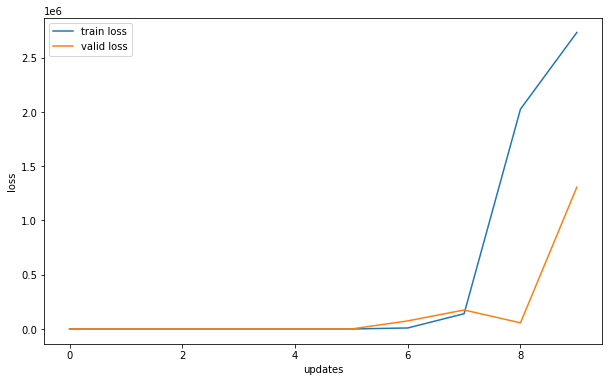

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 4. Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- feed the source sentence into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - place the current output and the two encoder outputs into the decoder
  - get next output token prediction from decoder
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [29]:
def translate_sentence(sentence, model, device, max_len = 50):

    model.eval()
    src_tensor = text_transform[SRC_LANGUAGE](sentence)
    # src_tensor = [src len]
    
    src_len = torch.tensor([len(src_tensor)])
    # src_len = [1]
    
    src_tensor = torch.LongTensor(src_tensor).unsqueeze(0).to(device)
    # src_tensor = [1, src len]
    
    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    
    trg_indexes = [SOS_IDX]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == EOS_IDX:
            break
        
    #convert integer back to string
    trg_tokens = vocab_transform[TRG_LANGUAGE].lookup_tokens(trg_indexes)
    
    return trg_tokens[1:], attention

Next, we have a function what will display how much the model pays attention to each input token during each step of the decoding.

In [30]:
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
    
    tokens = token_transform[SRC_LANGUAGE](sentence)
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Then we'll finally start translating some sentences.

First, we'll get an example from the training set:

In [31]:
valid_iter = Multi30k(split=('valid'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
sample = next(valid_iter)

In [32]:
#de
sentence = sample[0]
sentence = sentence.rstrip("\n")
sentence

'Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen'

In [33]:
#en
sample[1]

'A group of men are loading cotton onto a truck\n'

Then we pass it into our `translate_sentence` function which gives us the predicted translation tokens as well as the attention.

In [34]:
translation, attention = translate_sentence(sentence, model, device)
print(f'predicted trg = {translation}')

predicted trg = ['A', 'group', 'of', 'men', 'loading', '<unk>', 'on', 'a', 'truck', '.', '<eos>']


We can view the attention of the model, making sure it gives sensibile looking results.

/tmp/ipykernel_101/976105444.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'],
/tmp/ipykernel_101/976105444.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


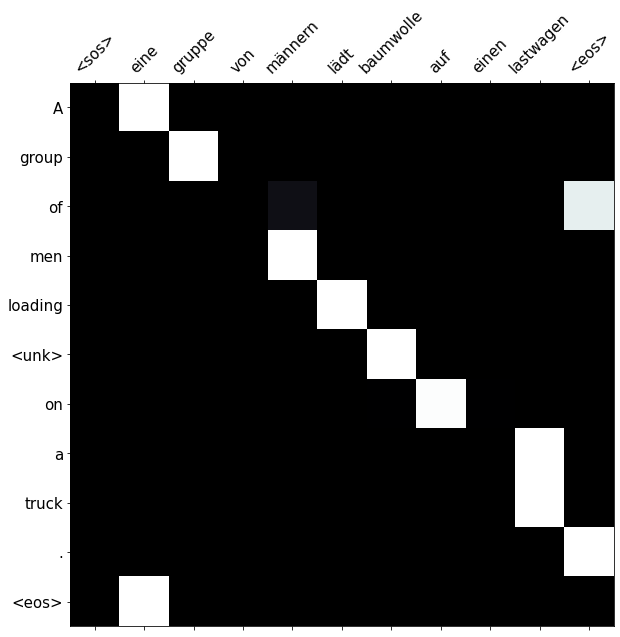

In [35]:
display_attention(sentence, translation, attention)

### BLEU

Finally, we calculate the BLEU score for the model.

In [36]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(iterator, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for src, trg in iterator:
        
        pred_trg, _ = translate_sentence(src, model, device, max_len)
                
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        #tokenize target sentence so it can be compared with pred_trgs
        trg = token_transform[TRG_LANGUAGE](trg.rstrip("\n"))

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [37]:
test_iter = Multi30k(split=('test'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
bleu_score = calculate_bleu(test_iter, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.19


We've now covered the first of our non-RNN using models! 

We will also be trying the `Transformer` model which doesn't even use convolutional layers - only linear layers and a lot of attention mechanisms.